## Importing Libraries and Configurations

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

## Loading the Dataset and Creating Splits

In [ ]:
dataset, dataset_info = tfds.load(name='malaria', with_info = True, as_supervised = True, shuffle_files = True, split= ['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
dataset

In [ ]:
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

## Data Visualization

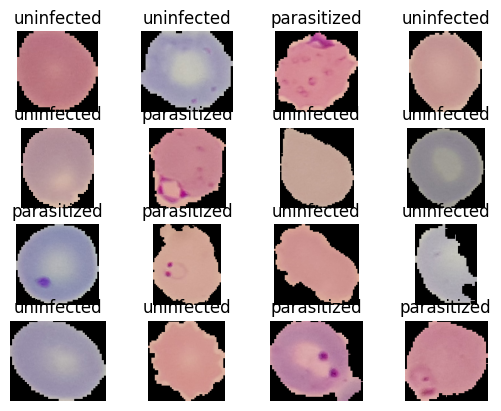

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(0), dataset_info.features['label'].int2str(1)

('parasitized', 'uninfected')

## Data Preprocessing

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
  image = tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0
  return image, label

In [ ]:
# train_dataset = train_dataset.map(lambda image, label: (tf.image.resize(image, (224, 224))/255.0, label))
# val_dataset = val_dataset.map(lambda image, label: (tf.image.resize(image, (224, 224))/255.0, label))
# test_dataset = test_dataset.map(lambda image, label: (tf.image.resize(image, (224, 224))/255.0, label))

In [ ]:
# for image, label in train_dataset.take(1):
#     print(image.shape)  # Should print (224, 224, number_of_channels)

In [ ]:
# train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

### Data Augmentation

In [ ]:
# Testing out different tf.image functions like
# flip_left_right
# flip_up_down
# rot90
# adjust_saturation
# random_saturation
# central_crop

In [ ]:
## tf.image augment
def augment(image,label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image,k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))
  #image = tf.image.adjust_saturation(image, 0.3)
  #image=tf.image.stateless_random_saturation(image, 0.3, 0.5)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [ ]:
class Rot90(Layer):
  def __init__(self):
    super(Rot90, self).__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image,k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [ ]:
### tf.keras.layer augment

augment_layers = tf.keras.Sequential([Rot90(),
                                      RandomFlip(mode = 'horizontal')])

### tf.keras.layer resizing and rescaling
resize_rescale_layer = tf.keras.Sequential([Resizing(IM_SIZE, IM_SIZE),
                                             Rescaling(1.0/255)])

In [ ]:
def augment_layer(image, label):
  image, label = resize_rescale(image, label)
  return augment_layers(resize_rescale_layer(image, training = True)), label

In [ ]:
# train_dataset = train_dataset.map(augment)
# val_dataset = val_dataset.map(augment)
# test_dataset = test_dataset.map(augment)

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original[0].numpy().astype("float32"))

  plt.subplot(1,2,2)
  plt.imshow(augmented[0].numpy().astype("float32"))

In [ ]:
image, label = next(iter(train_dataset))

# Convert image to float
original_image = tf.image.convert_image_dtype(image, tf.float32)

In [ ]:
augmented_image = tf.image.central_crop(original_image, 1)

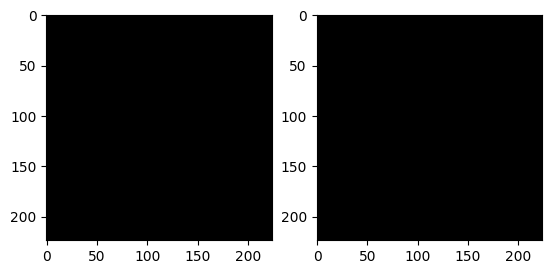

In [ ]:
visualize(original_image, augmented_image)

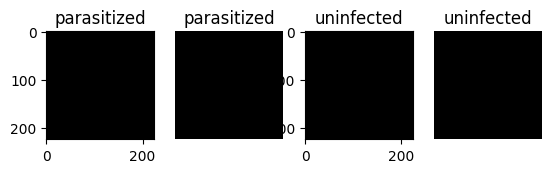

In [ ]:
#Its a bad idea to use saturation because it becomes hard for the model to detect the spot which indicates the cell is parasitized or not

for i, (image, label) in enumerate(train_dataset.take(2)):
    plt.subplot(1, 4, 2 * i + 1)
    plt.imshow(image[0])  # Convert tensor to numpy array and to uint8 for imshow
    plt.title(dataset_info.features['label'].int2str(label[0]))  # Convert tensor to numpy scalar

    plt.subplot(1, 4, 2 * i + 2)
    adjusted_image = tf.image.adjust_saturation(image[0], 0.3)
    plt.imshow(adjusted_image)  # Convert tensor to numpy array and to uint8 for imshow
    plt.title(dataset_info.features['label'].int2str(label[0]))  # Convert tensor to numpy scalar
    plt.axis('off')

In [ ]:
BATCH_SIZE = 32

train_dataset = (train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(augment_layer)
                 .batch(1).prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale_layer)
               .batch(1).prefetch(tf.data.AUTOTUNE))
test_dataset = test_dataset.map(resize_rescale_layer)

## MixUp Data Augmentation

In [ ]:
#Mixing 2 images or batch of images into 1

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

ValueError: in user code:

    File "<ipython-input-2-37a251fcdaa3>", line 3, in resize_rescale  *
        image = tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

    ValueError: 'images' must have either 3 or 4 dimensions.


In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
    .map(mixup, num_parallel_calls = tf.data.AUTOTUNE)
    #map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

## CutMix Data Augmentation

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
original_image, label = next(iter(train_dataset))
print(label)
plt.imshow(original_image[0])

## Albumentations


In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-3s9c3pj7
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-3s9c3pj7
  Resolved https://github.com/albu/albumentations to commit 30ac95ea943a6ff8824e34b4ef4b0954e8a3d6b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 118.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 236.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 275.9 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.8-py3-none-any.whl size=159499 sha256=3e0434f6b99ac057c0bbeff53fe3530633b58c319cb3d561cdeb6cc547e8b569
  Stored in directory: /tmp/pip-ephem-wheel-cache-wg1u84le/wheels/3c/df/16/b3d0d64428c9f25b1ab03989a2e574546d3336647946d31e56
Successfully built al

In [ ]:
transforms = A.Compose(
    [
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image


In [ ]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

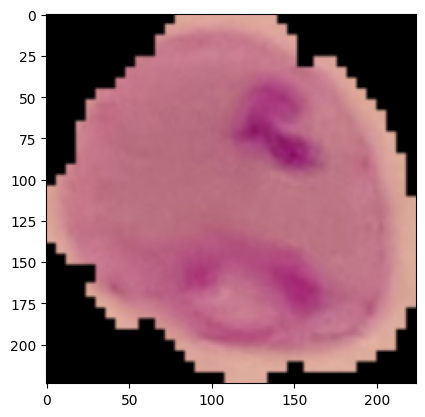

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

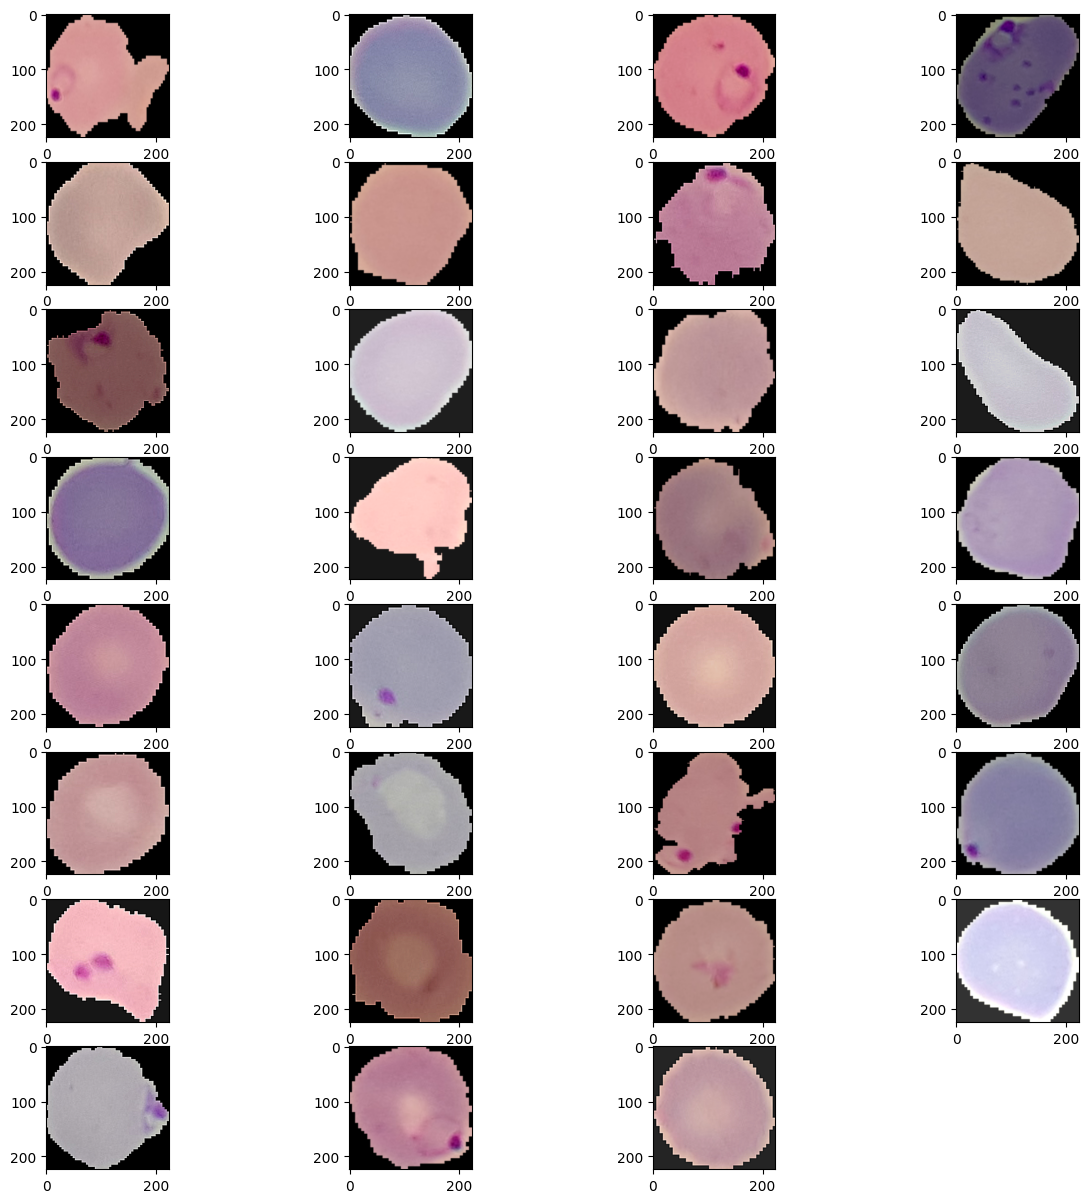

In [ ]:
plt.figure(figsize=(15,15))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])

## Model Creation



### Sequential API

In [ ]:
model = tf.keras.Sequential([
                             InputLayer(input_shape=(None, None, 3)),

                             resize_rescale_layer,
                             augment_layers,

                             Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides = 2),

                             Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides = 2),

                             Flatten(),

                             Dense(units = 100, activation = 'relu'),
                             BatchNormalization(),
                             Dense(units = 10, activation = 'relu'),
                             BatchNormalization(),
                             Dense(units = 1, activation = 'sigmoid')
                              ])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (224, 224, 3)             0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)     

### Functional API

In [ ]:
#feature_extractor_seq_model = tf.keras.Sequential([
                            #  InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                            #  Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
                            #  BatchNormalization(),
                            #  MaxPool2D (pool_size = 2, strides = 2),

                            #  Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
                            #  BatchNormalization(),
                            #  MaxPool2D (pool_size = 2, strides = 2),])

#feature_extractor_seq_model.summary()

In [ ]:
# func_input = Input(shape = (IM_SIZE, IM_SIZE, 3))

# layers = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation = 'relu')(func_input)
# layers = BatchNormalization()(layers)
# layers = MaxPool2D (pool_size = 2, strides = 2)(layers)

# layers = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation = 'relu')(layers)
# layers = BatchNormalization()(layers)
# output = MaxPool2D (pool_size = 2, strides = 2)(layers)

# feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
# feature_extractor_model.summary()

In [ ]:
# func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

# layers = feature_extractor_seq_model(func_input)

# layers = Flatten()(layers)

# layers = Dense(units = 100, activation = 'relu')(layers)
# layers = BatchNormalization()(layers)
# layers = Dense(units = 10, activation = 'relu')(layers)
# layers = BatchNormalization()(layers)
# func_output = Dense(units = 1, activation = 'sigmoid')(layers)

# lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
# lenet_model_func.summary()

## Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_2 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_6 (Bat  multiple                  400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_7 (Bat  multiple                  

### Custom Layer

In [ ]:
class NeuralearnDense(Layer):
    def __init__(self, output_units, activation=None, kernel_regularizer=None):
        super(NeuralearnDense, self).__init__()
        self.output_units = output_units
        self.activation = activation
        self.kernel_regularizer = kernel_regularizer

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_units": self.output_units,
            "activation": self.activation,
            "kernel_regularizer": self.kernel_regularizer
        })
        return config

    def build(self, input_features_shape):
        self.w = self.add_weight(
            shape=(input_features_shape[-1], self.output_units),
            initializer='random_normal',
            regularizer=self.kernel_regularizer,
            trainable=True
        )
        self.b = self.add_weight(
            shape=(self.output_units,),
            initializer='random_normal',
            trainable=True
        )

    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.w) + self.b

        if self.activation == 'relu':
            return tf.nn.relu(pre_output)
        elif self.activation == 'sigmoid':
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output


In [ ]:
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation = 'relu', kernel_regularizer = L2(0.01)),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides = 2),
                             Dropout(0.3),

                             Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation = 'relu', kernel_regularizer = L2(0.01)),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides = 2),

                             Flatten(),

                             NeuralearnDense(100, activation = 'relu', kernel_regularizer = L2(0.01)),
                             BatchNormalization(),
                             Dropout(0.3),

                             NeuralearnDense(10, activation = 'relu', kernel_regularizer = L2(0.01)),
                             BatchNormalization(),

                             NeuralearnDense(1, activation = 'sigmoid')
                              ])

lenet_custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 6)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Ba  (None, 109, 109, 16)     

## Hyperparameter tuning

In [ ]:
def model_tune(hparams):

  tuned_lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),
                             Dropout(rate = hparams[HP_DROPOUT]),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),

                             Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                             BatchNormalization(),
                             Dropout(rate = hparams[HP_DROPOUT]),

                             Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                             BatchNormalization(),

                             Dense(1, activation = "sigmoid")
                              ])

  tuned_lenet_custom_model.compile(optimizer = Adam(learning_rate = hparams[HP_LEARNING_RATE]),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

  tuned_lenet_custom_model.fit(train_dataset,validation_data=val_dataset, batch_size = 32, epochs=1)

  _, accuracy = tuned_lenet_custom_model.evaluate(val_dataset)
  return print(f"Accuracy: {accuracy}")

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('HP_NUM_UNITS_1', hp.Discrete([16, 32, 64, 128]))
HP_NUM_UNITS_2 = hp.HParam('HP_NUM_UNITS_2', hp.Discrete([16, 32, 64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.3, 0.4, 0.5]))
HP_REGULARIZATION_RATE = hp.HParam('HP_REGULARIZATION_RATE', hp.Discrete([0.001, 0.01, 0.1, 0.2]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout in HP_DROPOUT.domain.values:
      for regularizer in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout,
              HP_REGULARIZATION_RATE: regularizer,
              HP_LEARNING_RATE: learning_rate
          }

          file_witer = tf.summary.create_file_writer('logs/hparams_tuning/{hparams}' + str(run_number))

          with file_witer.as_default():
            hp.hparams(hparams)
            accuracy = model_tune(hparams)
            tf.summary.scalar(name = 'accuracy', data = accuracy)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

## Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs = None):
    print(f"\n Loss at epoch {epoch+1} is {logs['loss']}")
  def on_batch_end(self, batch, logs = None):
    print(f"\n Batch {batch+1} Loss is {logs['loss']}")

## CSV Logger

In [ ]:
csv_callback = tf.keras.callbacks.CSVLogger(
    'logs.csv',
    append=False,
    separator=',')

## EarlyStoping

In [ ]:
es_callback = EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = False, verbose = 1, mode = 'auto', baseline = None, min_delta=0)

## Learning rate Scheduler

In [ ]:
def scheduler(epoch, lr):
  if epoch < 3:
    learning_rate= lr
  else:
    learning_rate= lr * tf.math.exp(-0.1)
  with train_writer.as_default() as writer:
    tf.summary.scalar('Learning Rate', data = scheduler(epoch, lr), step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

## Model CheckPointing

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

## Reduce Learning rate on Plateau

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

## TensorBoard

In [ ]:
pip install -U tensorboard_plugin_profile

In [ ]:
metric_dir = './logs'
train_writer = tf.summary.create_file_writer(metric_dir + '/train')
val_writer = tf.summary.create_file_writer(metric_dir + '/val')

In [ ]:
current_time = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs' + current_time + '/metrics', histogram_freq=1, profile_batch = '100,129')

## Custom Metric Class

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
    super(CustomAccuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name = name, initializer = 'zeros')


  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred)*self.FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(len(output), dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

## Custom Metric Method(with Parameters)

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)* FACTOR
  return metric

## Custom Metric Method(without Parameters)

In [ ]:
def custom_accuracy(y_true, y_pred):
  print(binary_accuracy(y_true, y_pred))
  return binary_accuracy(y_true, y_pred)

## Custom Loss Class

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, factor):
    super(CustomBCE, self).__init__()
    self.factor = factor

  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.factor

## Custom Loss Method(with parameters)

In [ ]:
factor = 1
def custom_bce(y_true, y_predicted, factor):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* factor
  return loss

## Custom Loss Method(without parameters)

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

## Model Training

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'),TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')]

In [ ]:
lenet_custom_model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = CustomBCE(1),
              metrics = CustomAccuracy())

In [ ]:
history = lenet_custom_model.fit(train_dataset,validation_data=val_dataset, epochs = 5, verbose = 1, callbacks = [tensorboard_callback, scheduler_callback])

Epoch 1/5
 9075/19290 [=============>................] - ETA: 17:59 - loss: 1.1710 - custom_accuracy_1: 1.0000    

In [ ]:
cell_image = cv2.imread('cell_image.jpg')


cell_image = tf.expand_dims(cell_image, axis = 0)


model.predict(cell_image)

1/1 [==============================] - 0s 35ms/step


array([[0.]], dtype=float32)

## Custom training Loops

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

NameError: name 'Adam' is not defined

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = lenet_model(x_batch, training = True)
      loss = custom_bce(y_batch, y_pred)

  #wandb.log({'loss':loss.numpy()})
  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)

    print("Training Loss", loss)
    print("The accuracy is: ", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)

    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)

    METRIC_VAL.reset_states()
  print("Training Complete!!!!")

In [ ]:
neuralearn(lenet_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

In [ ]:
# image = cv2.imread('cell.jpg')
# print(image.shape)
# image = tf.expand_dims(image, axis = 0)
# print(image.shape)

# lenet_model.predict(image)

## Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []

In [ ]:
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
for i, element in enumerate(inp):
    print(f"Element {i} shape: {np.array(element).shape}")

Element 0 shape: (32, 224, 224, 3)
Element 1 shape: (32, 224, 224, 3)
Element 2 shape: (32, 224, 224, 3)
Element 3 shape: (32, 224, 224, 3)
Element 4 shape: (32, 224, 224, 3)
Element 5 shape: (32, 224, 224, 3)
Element 6 shape: (32, 224, 224, 3)
Element 7 shape: (32, 224, 224, 3)
Element 8 shape: (32, 224, 224, 3)
Element 9 shape: (32, 224, 224, 3)
Element 10 shape: (32, 224, 224, 3)
Element 11 shape: (32, 224, 224, 3)
Element 12 shape: (32, 224, 224, 3)
Element 13 shape: (32, 224, 224, 3)
Element 14 shape: (32, 224, 224, 3)
Element 15 shape: (32, 224, 224, 3)
Element 16 shape: (32, 224, 224, 3)
Element 17 shape: (32, 224, 224, 3)
Element 18 shape: (32, 224, 224, 3)
Element 19 shape: (32, 224, 224, 3)
Element 20 shape: (32, 224, 224, 3)
Element 21 shape: (32, 224, 224, 3)
Element 22 shape: (32, 224, 224, 3)
Element 23 shape: (32, 224, 224, 3)
Element 24 shape: (32, 224, 224, 3)
Element 25 shape: (32, 224, 224, 3)
Element 26 shape: (32, 224, 224, 3)
Element 27 shape: (32, 224, 224, 3)
El

In [ ]:
# expected_shape = (32, 224, 224, 3)
# processed_inp = []
# for element in inp:
#     element_array = np.array(element)
#     if element_array.shape == expected_shape:
#         processed_inp.append(element_array)
#     else:
#         # Handle padding or reshaping here if necessary
#         # For simplicity, let's just skip incompatible elements
#         print(f"Skipping element with shape {element_array.shape}")

# inp_array = np.array(processed_inp)


Skipping element with shape (7, 224, 224, 3)


In [ ]:
labels = np.array([i[0] for i in labels])
print(labels)

[0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0
 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0
 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1
 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0
 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0
 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0
 1]


In [ ]:
predicted = lenet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (260,) + inhomogeneous part.

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

ValueError: Found input variables with inconsistent numbers of samples: [130, 129]

### ROC Plots

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
print(len(fp), len(tp), len(thresholds))

NameError: name 'predicted' is not defined

In [ ]:
plt.plt(fp, tp)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i]])
plt.show()

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (<ipython-input-41-dbc9a1476be3>, line 11)

## Tensorboard Visualizations

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

## Training Graphs

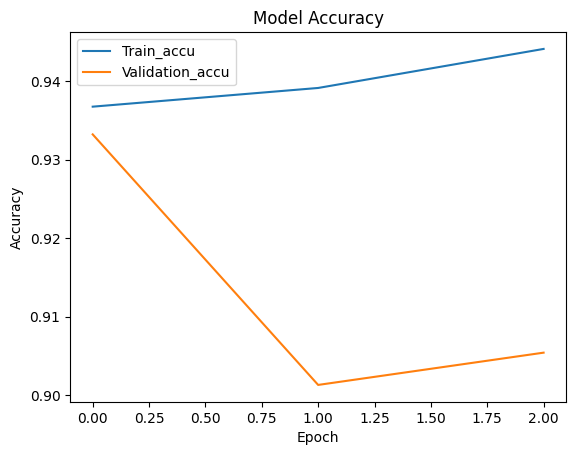

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_accu', 'Validation_accu'], loc = 'upper left')
plt.show()

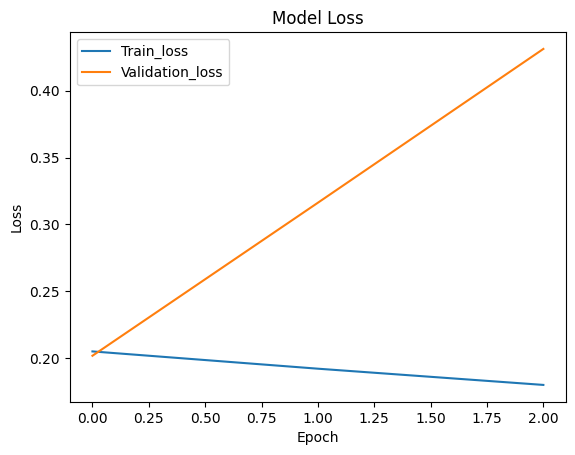

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Validation_loss'], loc = 'upper left')

## Model Evaluation and Testing

In [ ]:
model.evaluate(test_dataset)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
def parasite_or_healthy(x):
  if x > 0.5:
    return str('Parasitized')
  else:
    return str('Healthy')

In [ ]:
parasite_or_healthy(lenet_custom_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 15s 15s/step


'Healthy'

1/1 [==============================] - 0s 442ms/step


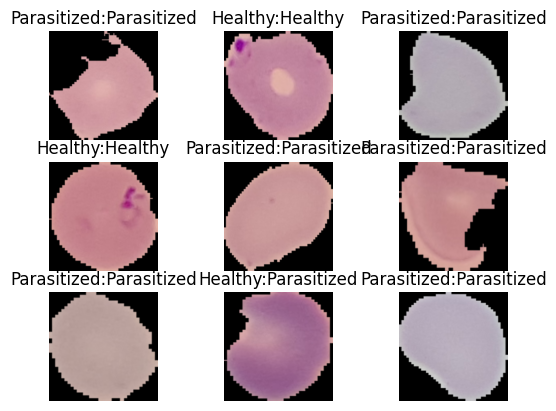

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_healthy(label.numpy()[0])) + ":" +str(parasite_or_healthy(lenet_custom_model.predict(image)[0][0])))
  plt.axis('off')

## Loading and Saving

In [ ]:
model.save("lenet")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()

In [ ]:
lenet_loaded_model.evaluate(test_dataset)

In [ ]:
model.save("lenet.hdf5")

In [ ]:
lenet_loaded_model_hdf5 = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model_hdf5.summary()

In [ ]:
model.save_weights("weights/lenet_weights")

In [ ]:
lenet_weights_model = model.load_weights("weights/lenet_weights")

## Saving to and Loading from Google Drive

In [ ]:
drive.mount('/content/drive/')

In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/ #Save the model to Google Drive

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet #Load the model from Google Drive